# Forberedelsen af data

In [13]:
#Libriaries & Models
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os

from IPython.display import clear_output
from skimage.io import imread
from skimage.transform import resize

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from scipy.spatial.distance import cdist
from scipy.linalg import pinv
from sklearn.metrics import mean_squared_error

import os
import pickle

import importlib
import src
importlib.reload(src)


Python random seed set.
NumPy random seed set.


<module 'src' from '/Users/hugojohnson/Desktop/Deep Learning/02456-deep-learning-project/src/__init__.py'>

In [14]:
X_train, X_test, y_train, y_test, scaler_X, scaler_y = src.dataset.load_split_data()

# Konverter til 3D-format for LSTM (samples, timesteps, features)
# Her antages en enkelt timestep, men du kan øge det, hvis du vil have flere tidssteg
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

print(X_train.shape)
print(X_train)

Loaded from pickle
(1280004, 1, 6)
[[[0.27781492 0.27613305 0.27907362 0.33076627 0.59965001 0.46896291]]

 [[0.03572272 0.03765466 0.03895277 0.53172522 0.46109047 0.3105202 ]]

 [[0.40172303 0.40345896 0.4018166  0.77613701 0.70351382 0.50930767]]

 ...

 [[0.38584042 0.38740846 0.38720072 0.50532798 0.76293038 0.37166716]]

 [[0.00867818 0.00795794 0.01189788 0.37043238 0.48856751 0.30589679]]

 [[0.67898445 0.67752782 0.67765178 0.0703512  0.62565837 0.48431389]]]


# RBF - Implementering

In [15]:
sigma = 1
num_centers = 30
class RBFNetwork:
    def __init__(self, centers, sigma):
        self.centers = centers.reshape(-1, centers.shape[-1])  # Centrene for RBF-enhederne (det skjulte lag)
        self.sigma = sigma      # Spredningsparameter for Gaussian-funktionen
        self.weights = None     # Vægte til outputlaget

    def _rbf(self, X):
        # Beregner radial basis-funktioner (Gaussian) for input X
        distances = cdist(X, self.centers, 'euclidean')  # Afstand fra input til hvert center
        # return np.exp(-distances ** 2 / (2 * self.sigma ** 2))  # Gaussian RBF
        return 1 / np.sqrt(distances ** 2 + self.sigma ** 2)  # Inverse Multiquadratic RBF
        # return np.sqrt(distances ** 2 + self.sigma ** 2) # Multiquadratic RBF
        # return distances # Linear

    def fit(self, X, y):
        # Træn modellen (beregn vægte baseret på målvariable y)
        G = self._rbf(X)  # Beregn aktiveringer i skjulte lag
        self.weights = pinv(G).dot(y)  # Beregn vægte for outputlaget (pseudo-invers)

    def predict(self, X):
        # Forudsig output for nye data
        G = self._rbf(X)
        return G.dot(self.weights)

random_indices = np.random.choice(X_train.shape[0], num_centers, replace=False)
centers = X_train[random_indices, :]
y_test = scaler_y.inverse_transform(y_test) # THIS MUST BE RUN ONLY ONCE.


In [16]:
cvalues = [100000, 10000, 1000, 100]
mses = []
print(y_test[:, 0])
for i in cvalues:
    rbf_net = RBFNetwork(centers, sigma=i)
    # print(y_train[:, 0].reshape(-1, 1).shape)
    # print(y_train[:, 0].reshape(-1, 1))
    # print(rbf_net.centers.shape)
    # print(X_train.reshape(-1, X_train.shape[-1]).shape)
    # print(y_train[:, 0].reshape(-1, 1))
    rbf_net.fit(X_train.reshape(-1, X_train.shape[-1]), y_train[:, 1].reshape(-1, 1)) # COLUMN 1.
    # rbf_net.fit(X_train, y_train)

    y_pred = rbf_net.predict(X_test.reshape(-1, X_train.shape[-1]))

    # Reverse the transform
    y_pred_full = np.zeros((y_pred.shape[0], 3)) # A placeholder array with 3 columns
    y_pred_full[:, 0] = y_pred.flatten()
    y_pred = scaler_y.inverse_transform(y_pred_full)[:, 0]

    # Beregn MSE
    mse = mean_squared_error(y_test[:, 0].reshape(-1, 1), y_pred)
    mses.append(mse)
    # print("Mean Squared Error på testdata:", mse)

print(y_test[:, 0])

[-31.55766296   6.27371645  11.63013554 ... -56.03583145  43.7670784
 -51.68685913]
[-31.55766296   6.27371645  11.63013554 ... -56.03583145  43.7670784
 -51.68685913]


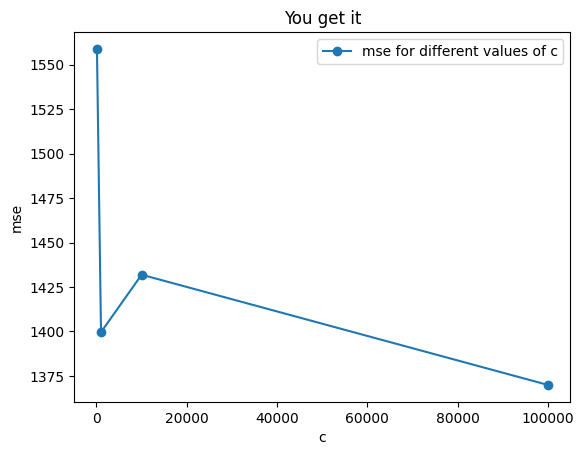

In [17]:
# Create the plot
plt.plot(cvalues, mses, label='mse for different values of c', marker='o')  # Add markers for better visualization (optional)

# Add labels and title
plt.xlabel('c')
plt.ylabel('mse')
plt.title('You get it')

# Optional: Add a legend
plt.legend()

# Display the plot
plt.show()


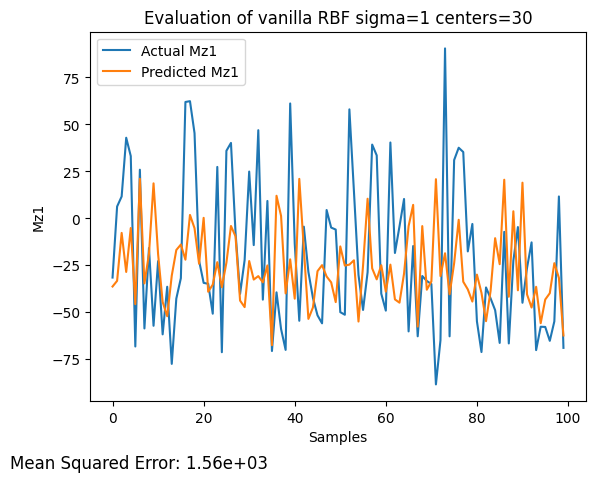

In [18]:
src.plots.evaluate_predictions(y_pred[:100], y_test[:, 0][:100], mse, name=f"vanilla RBF sigma={sigma} centers={num_centers}")